# Titanic - Machine Learning From Disaster
This is the first project out of my ten projects journey to learn data science and machine learning. The objectives of this project are:
- Get started
- Learn about classification
- Learn about data engineering
- Learn about decision trees

# Exploratory analysis
Based on [Exploratory Data Analysis of Titanic Survival Problem](https://medium.com/analytics-vidhya/exploratory-data-analysis-of-titanic-survival-problem-e3af0fb1f276)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re # Regular expression

## Variables study

In [2]:
df = pd.read_csv("../data/train.csv")
df.shape

(891, 12)

In [3]:
cols = df.columns
cols

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [4]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


**Count** is the number of entries in a particular column, we can see that Age is incomplete. 

**Mean** is the average of each column. E.g. The average fare us 32.2 USD

**Std** is standard deviation of all data. A low standard deviation means that most of the numbers are close to the average, while a high standard deviation means that the numbers are more spread out. Again ‘Fare’ has a high standard deviation.

**Min** is the minimum value of each column. For example, the lowest ‘Fare’ shows 0 USD, which means ‘Fare’ is unavailable for some passengers. The model may not perform well with 0 for some passengers. Hence we will need to focus on the ‘Fare’ column before modeling.

**Max** is the maximum value of the column. For example, the highest ‘Fare’ shows 512.33 USD. The mean of the ‘Fare’ column says USD 32.20. We see there is a huge difference in fare. It could be because of the ‘Pclass’ they were traveling.

**25%, 50% & 75%** are the 1st, 2nd, and 3rd quartile of the data. Quartile in statistics is a type of quantile that divides the number of ordered data points into four equal groups. 1st quartile is the middle number between the smallest number and the median. 2nd quartile is the median of the dataset. 3rd quartile is the middle value between the median and the highest value.


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

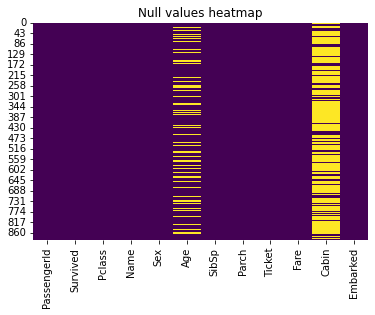

In [7]:
ax = plt.axes()
sns.heatmap(df.isnull(), cmap = 'viridis', cbar=False, ax=ax)
ax.set_title('Null values heatmap')
plt.show()

## Data cleaning

Since cabin has a lot of NaN values, we will create a new feature called has cabin which will have 1 for Cabin a 0 for NaN values.

In [8]:
df['has_cabin'] = np.where(df['Cabin'].isnull(), 0, 1)

Now for the embarked missing values, we will assign S (Southhampton)

In [9]:
df['Embarked'] = df['Embarked'].fillna('S')

Age feature has a lot of missing values. We will fill them with random values centered around the mean and distributed with standard deviation.

In [10]:
mean = df['Age'].mean()
std = df['Age'].std()
print(f'Mean: {mean}, Std: {std}')

Mean: 29.69911764705882, Std: 14.526497332334042


In [11]:
min = mean - std
max = mean + std
df['Age'] = df['Age'].fillna(np.random.randint(min, max))

## Feature engineering
Here we will create new features that could help our model performance.

We will create a new feature called family_size by combining ‘SibSp’(Sibling & Spouse) and ‘Parch’(Parent & Children).

In [12]:
df['family_size'] = df['SibSp'] + df['Parch'] + 1

Next, we will create another feature called is_alone which is 1 for people travelling alone and 0 for the rest.

In [13]:
df['is_alone'] = np.where(df['family_size'] == 0, 1, 0)

The fare column contains 0's for some passangers and pretty high values for others. We will split the fare into four categories and create a new feature called categorical_fare

In [14]:
df['categorical_fare'] = pd.qcut(x=df['Fare'], q=4, labels=[0, 1, 2, 3]).astype(int)

Next, let's categorize the age into five categories and create a new feature "categorical_age"

In [15]:
df['categorical_age'] = pd.qcut(x=df['Age'], q=5, labels=[0, 1, 2, 3, 4]).astype(int)

In the name column we have many titles, we will extract them and categorize them into four categories [Mr, Miss, Mrs, Rare] and create a new feature called "title"

In [16]:
def find_title(name : str) -> str:
    search = re.search(' ([A-Za-z]+)\.', name) # Search for a word with a point at the end
    if search:
        title = search.group(1)
        if title in ['Mlle', 'Ms']:
            return 'Miss'
        elif title in ['Mme', 'Mrs']:
            return 'Mrs'
        elif title == 'Mr':
            return 'Mr'
        else:
            return 'Rare'
    return ""

return_title = df['Name'].apply(find_title)
dict_title = {'Miss': 1, 'Mrs':2, 'Mr':3, 'Rare':4}
df['Title'] = return_title.replace(dict_title)

Lastly, we will change the "Sex" and "Embarked" feature to categorical ones. Machine Learning algorithms operate in the domain of numerical values. They do not understand “Male/Female” or “Yes/No”. But they understand the difference between a 0 and a 1.

In [17]:
df['sex_numerical'] = np.where(df['Sex'] == 'male', 1, 0)
df['Embarked'] = df['Embarked'].replace({'S': 0, 'C' : 1, 'Q' : 2})

After data cleaning and feature engineering we check for NaN values

In [18]:
df.isnull().sum()

PassengerId           0
Survived              0
Pclass                0
Name                  0
Sex                   0
Age                   0
SibSp                 0
Parch                 0
Ticket                0
Fare                  0
Cabin               687
Embarked              0
has_cabin             0
family_size           0
is_alone              0
categorical_fare      0
categorical_age       0
Title                 0
sex_numerical         0
dtype: int64

Let's drop the useless columns.

In [19]:
drop_list = ['PassengerId', 'Cabin', 'Ticket', 'SibSp', 'Name']
df = df.drop(drop_list, axis=1)
df.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,has_cabin,family_size,is_alone,categorical_fare,categorical_age,Title,sex_numerical
0,0,3,male,22.0,0,7.2500,0,0,2,0,0,1,3,1
1,1,1,female,38.0,0,71.2833,1,1,2,0,3,3,2,0
2,1,3,female,26.0,0,7.9250,0,0,1,0,1,1,4,0
3,1,1,female,35.0,0,53.1000,0,1,2,0,3,3,2,0
4,0,3,male,35.0,0,8.0500,0,0,1,0,1,3,3,1


## Correlation study

<AxesSubplot:>

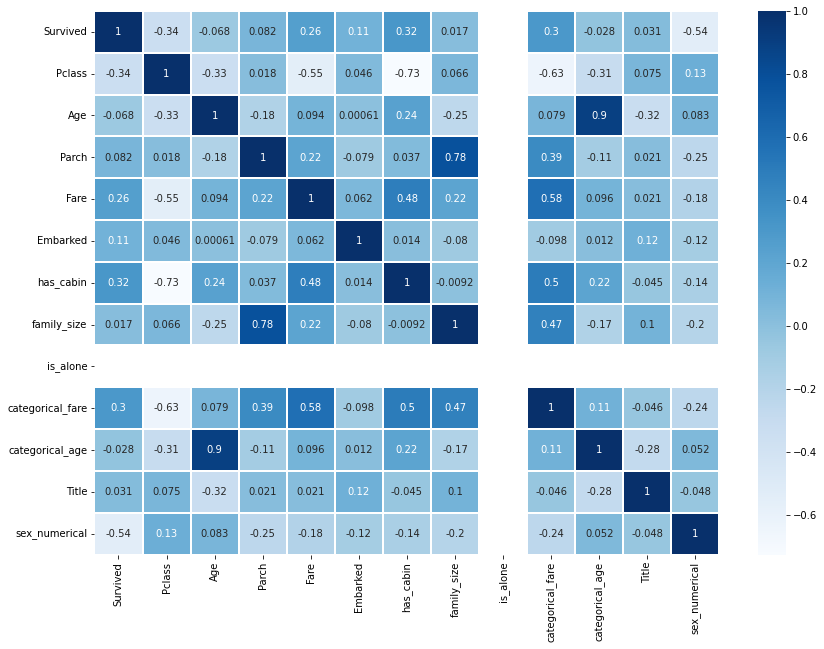

In [22]:
colormap = plt.cm.Blues
plt.figure(figsize=(14,10))
sns.heatmap(df.corr(), cmap=colormap, annot=True, linewidths=0.2)

Positive and Negative values denote Positive and Negative correlation. The first row of the data shows the correlation of each variable with the Target variable ‘Survived’.
For building a good predictive model, we are interested in variables that influence the target variable “Survived”. Positively or negatively. We need to consider the values that are both too high and too low.`

The first row contains the values that represent the correlation of each variable with the target variable. ‘HasCabin’ and ‘CategoricalFare’ are highly (positively) correlated with the target variable and ‘Sex Numerical’ is inversely correlated with the target variable.

## Target Variable Analysis (Univariate Analysis)
The Study of the target variable is a significant step in Data Analysis that reveals the nature and distribution of the variable. Let’s analyze our target variable “Survived”.

In [24]:
df['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

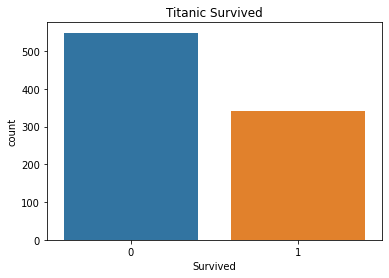

In [28]:
sns.countplot(x='Survived', data=df)
plt.title("Titanic Survived")
plt.show()

<AxesSubplot:ylabel='Survived'>

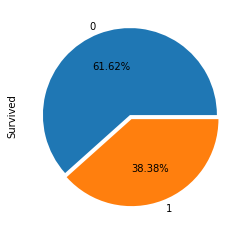

In [30]:
explode = [0, 0.05]
df['Survived'].value_counts().plot.pie(autopct = '%1.2f%%', explode=explode)

From the above chart, 38% of the passengers are only survived based on this training data. Clearly, there is an imbalance between the classes.
## Bivariate analysis
Let's analyze the ‘Pclass’ column since it is highly correlated with the target variable.

In [34]:
df['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [37]:
df.groupby(['Pclass', 'Survived'])['Survived'].count()

Pclass  Survived
1       0            80
        1           136
2       0            97
        1            87
3       0           372
        1           119
Name: Survived, dtype: int64

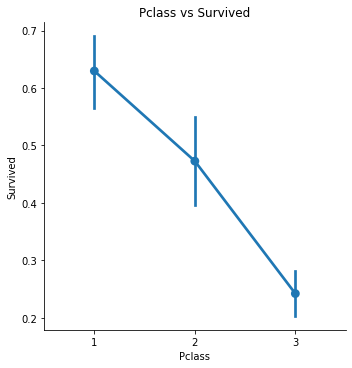

In [41]:
sns.catplot(x='Pclass', y='Survived', data=df, kind='point')
plt.title("Pclass vs Survived")
plt.show()

What you see above is called a Point plot. It shows point estimates and confidence intervals. The point estimates indicate the central tendency of a variable while the confidence intervals indicate the uncertainty around this estimate. From the above plot, it is very clear that the first Class passengers had the highest Survival rate when compared to the other class passengers.

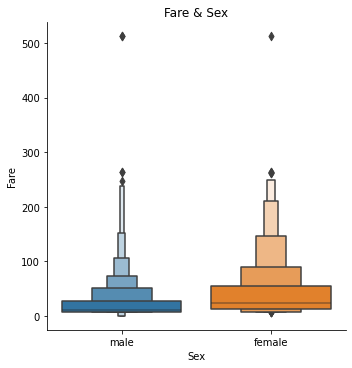

In [43]:
sns.catplot(x='Sex', y='Fare', data=df, kind='boxen')
plt.title("Fare & Sex")
plt.show()

The enhanced box plot shown above indicates that the fare of “Female” passengers is on average higher than male passengers. It could be because of the additional services offered to female passengers.